# Boosting für Machine Learning

Wir beschäftigen uns mit den grundlegenden Varianten des sogenannten _Boostings_.
Dabei legen wir unser Augenmerk auf Boosting für die Klassifikation.
Insbesondere klassifizieren wir Reden von deutschen Politikern, d.h. aus einem gegebenen Redetext ermitteln wir wer diese Rede hielt.
(Diese Problemstellung war bereits Thema im [codecentric.AI Bootcamp](https://www.codecentric.de/kuenstliche-intelligenz/) im Abschnitt [Natural Language Processing](https://www.youtube.com/watch?v=GmLsb-o7hvM).)

Boosting dreht sich um die folgende Frage.

_Angenommen für unser Problem steht ein schlechter Klassifikator K zur Verfügung._
_Wie können wir aus K einen guten Klassifikator K' erzeugen?_

Unter einem schlechten Klassifikator verstehen wir einen Klassifikator mit schlechter Vorhersagekraft, d.h. er macht viele Fehler.
(Die Theorie erlaubt sogar so viele Fehler, dass die Kraft nur wenig besser als zufälliges Raten ist!)
Der neue Klassifikator K' wird keine abgewandelte Form von K sein, sondern K' besteht aus mehreren geschickt kombinierten Instanzen von K.
Daher bezeichnet man K' auch als _Ensemble_.

Ensembles lassen sich aus unterschiedlichen Typen von Klassifikatoren erstellen.
Hier beschränken wir uns auf den Fall, dass K ein einfacher [Entscheidungsbaum](https://en.wikipedia.org/wiki/Decision_tree_learning) ist.
Die Klassifikation des Ensembles K' ergibt sich aus den individuellen Klassifikationen der beteiligten Entscheidungsbäume.

Im Rest des Artikels stellen wir verschiedene Verfahren je in einer kurzen allgemeinen Form vor, orientieren aber nähere Erläuterungen an der Implementierung mit Entscheidungsbäumen.
Bemerke, dass wir kein Tuning der Implementierung durchführen, sondern uns vielmehr darauf konzentrieren die Unterschiede der Verfahren zu zeigen.

## Daten laden

Werfen wir zuerst einen Blick auf die Daten.
Wir verwenden den von Barbaresi und Adrien bereitgestellten Datensatz [1], der unter der URL [2] verfügbar ist.

[1] Barbaresi, Adrien (2018). "A corpus of German political speeches from the 21st century", Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

[2] http://purl.org/corpus/german-speeches

Vorab ein Einblick in wenige zufällig ausgewählte Reden.
(Hier wie auch unten lagern wir Code aus, welcher uns vom roten Faden wegführt, und binden ihn per `%run` ein.)

In [1]:
%run define_load_data_functions.ipynb

df = load_data()

display(df.sample(n=5))

,person,speech
249,Gerhard Schröder,".\nAnrede!\nEs ist mir eine besondere Freude, ..."
2495,Angela Merkel,"Sehr geehrter Herr Regierender Bürgermeister, ..."
73,Christina Weiss,"beim ""letzten Blick"" auf das Neue Museum mag z..."
1112,Bernd Neumann,"""Europa ist ein facettenreicher, farbenprächti..."
1964,Angela Merkel,"Ich freue mich sehr, dass ich mit Ihnen diese ..."


Im Datensatz ist Angela Merkel mit der weitaus stärksten Anzahl von Reden vertreten.

In [2]:
speech_counts = df.person.value_counts()

display(speech_counts)

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Wir beschränken uns auf die binäre Klassifikation, d.h. wir unterscheiden nur zwischen zwei Klassen von Personen.
Um auf ausgewogenen Daten zu arbeiten wählen wir die Klassen _Angela Merkel_ und _Nicht Angela Merkel ("Andere")_.
Dazu vernachlässigen wir zuerst alle Personen, die mit nur wenigen Reden vertreten sind.

In [3]:
MIN_NUM_SPEECHES = 100
belowThreshold = lambda name: speech_counts[name] < MIN_NUM_SPEECHES

dropped = filter(belowThreshold, df.person.tolist())
df.drop(df[df.person.isin(dropped)].index, inplace=True)

display(df.person.value_counts())

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

Dann fassen wir alle verbleibenden Personen zur Klasse _Andere_ zusammen.

In [4]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'

display(df.person.value_counts())

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

## Daten vorverarbeiten

Es folgt eine Vorverarbeitung der Reden mit Hilfe der NLP-Bibliothek [spaCy](https://spacy.io/).
In diesem Schritt zerlegen wir jede Rede in ihre (durch Whitespace getrennten) Bestandteile, die sogenannten _Tokens_.
In dem Zuge entfernen wir Tokens mit geringer Information, wie z.B. Interpunktion und Stoppwörter ("und", "der", "die", "das", ...).
Außerdem überführen wir jedes Token in seine Grundform, das sogenannte _Lemma_ (z.B. "angekündigt" -> "ankündigen").

In [5]:
%run init_spacy.ipynb
%run define_preprocessing.ipynb

df = load_cached_or_preprocess(df.speech)

display(df.head())

,person,speech,tokens,lemmata
0,Andere,"es ist angekündigt worden, man sollte im Beruf...","[angekündigt, Beruf, Schauspieler, Politiker, ...","[ankündigen, berufen, schauspielern, Politiker..."
2,Andere,Frage (Peter Hahne): Bevor wir uns über den Au...,"[Frage, Peter, Hahne, Bevor, Aufbau, Ost, Arbe...","[Frage, Peter, Hahn, bevor, Aufbau, Ost, Arbei..."
3,Andere,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...","[Satz, Herr, Dr., Bernotat, aufgeschrieben, Ar...","[Satz, Herr, Dr., Bernotat, aufschreiben, Argu..."
4,Andere,diese Jahresversammlung der Hochschulrektorenk...,"[Jahresversammlung, Hochschulrektorenkonferenz...","[Jahresversammlung, Hochschulrektorenkonferenz..."
5,Andere,"ich habe nie einen Hehl daraus gemacht, dass i...","[Hehl, Stadt, komme, Amtszeit, Gast, gefühlt, ...","[Hehl, Stadt, kommen, Amtszeit, gasen, fühlen,..."


Für jede Rede R überführen wir nun die Folge von Lemmata von R in das "Histogramm" der Lemmahäufigkeiten von R.
Bemerke, dass wir dabei die Reihenfolge der Worte vergessen.
(Man nennt solch eine vereinfachte Darstellung einer Wortfolge auch _bag of words_, um das Abhandensein von zeitlicher Information zu betonen.)
Dann schauen wir uns ein paar Lemmata und die gewonnene Darstellung einer Rede im Detail an.

(Einige Lemmata sind nicht "perfekt".
Sie enthalten etwa Bindestriche oder liegen in gebeugter Form vor.
Hier wird die Unschäfe der Sprache und ihrer Verarbeitung deutlich.
Beispielsweise geschieht Lemmatisierung in spaCy nicht durch Anwendung eines Regelwerks, sondern durch neuronale Netze, die natürlich nicht in allen Fällen korrekte Ergebnisse erzielen.)

In [6]:
%run define_feature_computation.ipynb

(lemmata, lemma_index) = compute_index(df["lemmata"])
df["lemma_counts"] = count(df["lemmata"], lemma_index)

display(lemmata[0:10])
display(df.iloc[11]) # In lemma_counts ist jedes Lemma durch eine Nummer repräsentiert.

['Kahlschlag',
 'außenstehender',
 'augenscheinlich',
 'Indische',
 'zweitbeliebteste',
 'Spitzennationen',
 'Bernardo',
 'Ramazanlar',
 'Timken',
 'Rambin']

person                                                     Andere
speech          Wenn es um die Geschichte und um Erinnerung ge...
tokens          [Geschichte, Erinnerung, Zahlen, guten, Ruf, Z...
lemmata         [Geschichte, Erinnerung, Zahl, gut, rufen, Zah...
lemma_counts    {77117: 3, 75813: 5, 90746: 4, 93008: 1, 20746...
Name: 15, dtype: object

## Training

Bis hier haben wir aus den Reden die für das Modell-Training benötigten statistischen Informationen extrahiert.
Zum Start des Trainings fehlt nur noch die Konvertierung in das benötigte Eingabedatenformat.

Zum Training nutzen wir die ML-Bibliothek [scikit-learn](https://scikit-learn.org/stable/).
Die eingegebenen Trainingdaten bestehen aus einer Sammlung von sogenannten _Labels_ (eins pro Rede) und sogenannten _Featurevektoren_ (ebenfalls einer pro Rede).
In unserem Fall gibt das Label einer Rede R an, welche Person die Rede R hielt (_Angela Merkel_ oder _Andere_).
Der Feature-Vektor von R kodiert das Histogramm der Lemmahäufigkeiten von R (haben wir oben bereits berechnet).

Für die Eingabe in die Algorithmen von scikit-learn werden alle Labels in einen Vektor zusammengefasst.
Analog werden alle Featurevektoren zu einer Matrix zusammengefasst.
Dafür müssen natürlich alle Featurevektoren die gleiche Länge haben, was wir mit Hilfe der Funktion `dict_to_sparse` erledigen.
(Insbesondere gibt diese Funktion eine sogenannte _dünn besetzte Matrix_ aus, in der Einträge mit Wert Null nicht explizit gespeichert werden.
Warum?
In einer gegebenen Rede erscheinen bei Weitem nicht alle möglichen Lemmata, folglich enthält jeder Featurevektor viele Nullen.
Folglich ist auch die Matrix voller Nullen.
Ohne explizite Darstellung sparen wir also viel Speicherplatz.)

In [7]:
%run define_conversion_functions.ipynb

feature_vectors = dict_to_sparse(df["lemma_counts"], len(lemma_index))
categories = df["person"].astype("category")
labels = categories.cat.codes

Möge das Training beginnen.
Wir erinnern uns, dass wir Ensembles von schwachen Klassifizierern erstellen möchten.
Als schwachen Klassifizierer wählen wir einen sogenannten _Decision Stump_, d.h. einen Entscheidungsbaum der Tiefe 1.

In [8]:
from sklearn.tree import DecisionTreeClassifier

DECISION_TREE_DEPTH=1

def generate_decision_stump():
    return DecisionTreeClassifier(max_depth=DECISION_TREE_DEPTH)

Zum Warmwerden trainieren wir zunächst einen einzelnen Stump.

Dafür werden unsere Eingabedaten in Trainingdaten und Testdaten zerlegt, und zwar im üblichen Verhältnis 70/30.
Nur die Trainingsdaten werden für das tatsächliche Training verwendet.
Mit Hilfe der Testdaten wird die Performance des fertig trainierten Stumps evaluiert.

Damit wir die Performance verlässich evaluieren können, führen wir das Experiment nicht nur einmal durch, sondern wiederholen es 20 Mal und mitteln die Ergebnisse.
Die _Accuracy_ zeigt uns wie viele Testdatensätze korrekt klassifiziert wurden.
Die sogenannte _Confusion Matrix_ schlüsselt die korrekten und falschen Klassifizierungen auf (in der i-ten Zeile und j-ten Spalte steht wie viele Reden von "i" als Reden von "j" klassifiziert wurden).
Wir sehen, dass nicht einmal 80% der Testdaten korrekt klassifiziert werden, wobei mehr Reden von Angela Merkel falsch klassifiziert wurden (über 30%) als Reden von anderen (ca. 10%).

'Repetition 0'

'Repetition 1'

'Repetition 2'

'Repetition 3'

'Repetition 4'

'Repetition 5'

'Repetition 6'

'Repetition 7'

'Repetition 8'

'Repetition 9'

'Repetition 10'

'Repetition 11'

'Repetition 12'

'Repetition 13'

'Repetition 14'

'Repetition 15'

'Repetition 16'

'Repetition 17'

'Repetition 18'

'Repetition 19'

0.766546762589928

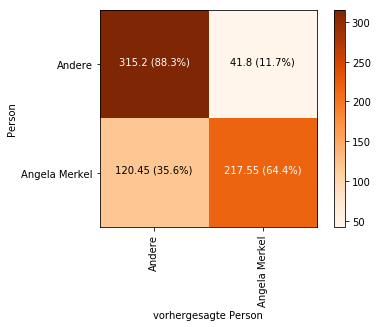

In [9]:
%run define_plot_functions.ipynb
%run define_train_functions.ipynb

TRAIN_TEST_RATIO = 0.3
REPETITIONS = 20

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_decision_stump, 
    data=feature_vectors,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

Wir werfen einen Blick in die Blackbox und betrachten einen der trainierten Decision Stumps genauer.
Interessant ist insbesondere die erste Zeile des Wurzelknotens.
Die Häufigkeit genau eines Lemmas bestimmt welchem der beiden Blätter eine Rede zugeordnet wird.
Jedes Blatt klassifiziert alle ihm zugeordneten Reden mit der gleichen Person, wie die jeweils letzte Zeile zeigt.

(Die Werte _samples_ und _value_ zeigen wie viele Reden dem jeweiligen Knoten zugeordnet werden bzw. die vom Knoten berechnete Redner-Verteilung aller dem Knoten zugeordneten Reden.)

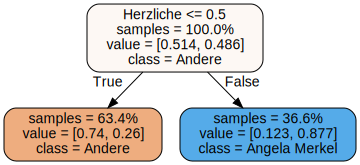

In [10]:
display_decision_tree(classifiers[0])

Beachte, dass dieser Stump einen Schnitt durch einen n-dimensionalen Raum darstellt, wobei n die Anzahl der Lemmata ist.
Eine Visualisierung durch bspw. eine Fläche ist also nicht möglich.

### Bagging
Bisher haben wir mehrere Stumps unabhängig voneinander trainiert und ihre mittlere Performance betrachtet.
Diese Idee verfolgt auch das sogenannte _Bagging_ (kurz für _bootstrap aggregating_).
Bagging erstellt ebenfalls ein Ensemble von unabhängigen Stumps, wendet die Mittelung jedoch schon früher an, nämlich zur Klassifizierung einer Rede.

Wir erstellen ein Ensemble von 20 unabhängigen Decision Stumps, wobei für jeden eine zufällige Teilmenge der Trainingsdaten verwendet wird.
Da die Berechnungen der individuellen Stumps nicht voneinander abhängen, können wir mit Hilfe von allen zur Verfügung stehenden CPUs parallelisieren.

<img src="images/20190102_151532.jpg" width="50%">

Das Bagging-Ensemble kombiniert die Vorhersagen der individuellen Stumps zu einer einzigen Vorhersage.
Wenn die Person für Rede R vorhergesagt werden soll, wird nicht einfach nur unter allen individuellen Vorhersagen abgestimmt, sondern die individuellen Vorhersagewahrscheinlichkeiten beider Personen für R gemittelt und dieses Mittel zur finalen Vorhersage verwendet.

<img src="images/20190102_151541.jpg" width="50%">

Bemerke, dass wir keine Verbesserung der Performance gegenüber unserem Experiment aus dem vorangehenden Abschnitt erzielen.
Grund ist, dass jeder Bagging-Klassifizierer im Wesentlichen unsere Mittelung nachstellt.
Die Wiederholung des Baggings und die anschließende Mittelung über die Performances der Ensembles verändert die einzelnen Ergebnisse nicht entscheidend.

'Repetition 0'

'Repetition 1'

'Repetition 2'

'Repetition 3'

'Repetition 4'

'Repetition 5'

'Repetition 6'

'Repetition 7'

'Repetition 8'

'Repetition 9'

'Repetition 10'

'Repetition 11'

'Repetition 12'

'Repetition 13'

'Repetition 14'

'Repetition 15'

'Repetition 16'

'Repetition 17'

'Repetition 18'

'Repetition 19'

0.7844604316546762

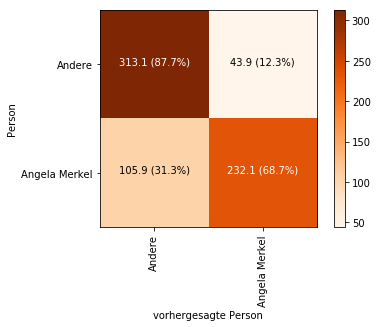

In [11]:
from sklearn.ensemble import BaggingClassifier

NUM_BASE_ESTIMATORS = 20
ALL_CORES = -1

def generate_bagging_classifier():
    return BaggingClassifier(base_estimator=generate_decision_stump(),
                             n_estimators=NUM_BASE_ESTIMATORS,
                             n_jobs=ALL_CORES)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_bagging_classifier, 
    data=feature_vectors,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

# Boosting

Die Performance des schwachen Decision Stumps und des naiven Baggings können wir sicherlich verbessern.
Erfreulich wird sein, mit welch einfachen Mitteln das gelingt!

## AdaBoost

[AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) erstellt ebenfalls ein Ensemble von schwachen Klassifizierern.
Die Klassifizierer sind im Gegensatz zum Bagging aber nicht unabhängig voneinander.
Erstellt wird nämlich eine _Folge_ von Klassifizierern, wobei sich die Performance eines Klassifizierers auf das Training des nächsten auswirkt.
Ziel ist es, Schwächen des Klassifizierers zu identifizieren, diese Schwächen in weiteren Trainings zu kompensieren und schließlich stark aus dem finalen Trainingsplan hervorzugehen.

Wie trainiert AdaBoost in unserem Fall?
Für jeden fertig trainierten Stump S werden falsch klassifizierte Reden identifiziert.
Diese Reden stellen offenbar "schwierige" Eingaben für S dar - sonst würde sie ja von S korrekt zugeordnet.
Solch schwierige Reden werden mit erhöhter Wahrscheinlichkeit ausgewählt, wenn eine zufällige Trainingsmenge für den nächsten Stump erzeugt wird.
Das kommende Training ist also mit einer "schwierigeren" Eingabe konfrontiert, welche mehr Informationen über die Gesamtmenge aller Reden innehat.
(Tatsächlich wird die Auswahlwahrscheinlichkeit _korrekt_ von S klassifizierter Reden _verringert_.
Der Verringerungsfaktor ergibt sich aus dem _Fehler von S_, der Wahrscheinlichkeit eine zufällig gemäß aktueller Verteilung gezogene Rede falsch zu klassifizieren.)

<img src="images/20190102_172653.jpg" width="50%">

Wie klassifiziert AdaBoost?
Jeder Stump des Ensembles beeinflusst die Gesamtvorhersage mit unterschiedlichem Gewicht.
Das Gewicht für Stump S ergibt sich aus dem Fehler von S:
Je kleiner der Fehler, umso größer der Einfluss von S.

<img src="images/20190102_175314.jpg" width="50%">

Das Ergebnis unseres Experiments:
Im Schnitt erreicht ein AdaBoost-Klassifier eine Genauigkeit von über 90% (mit Bagging erreichten wir nur unter 80%).
Fehlklassifizierungen liegen nun im einstelligen Prozentbereich.

'Repetition 0'

'Repetition 1'

'Repetition 2'

'Repetition 3'

'Repetition 4'

'Repetition 5'

'Repetition 6'

'Repetition 7'

'Repetition 8'

'Repetition 9'

'Repetition 10'

'Repetition 11'

'Repetition 12'

'Repetition 13'

'Repetition 14'

'Repetition 15'

'Repetition 16'

'Repetition 17'

'Repetition 18'

'Repetition 19'

0.928201438848921

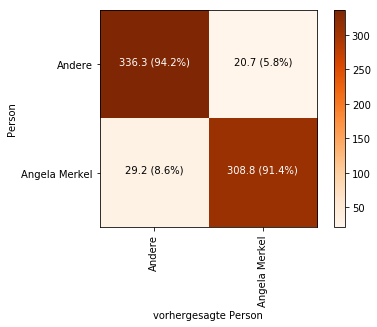

In [12]:
from sklearn.ensemble import AdaBoostClassifier

# keine parallele Berechnung der Sequenz möglich
def generate_adaboost_classifier():
    return AdaBoostClassifier(base_estimator=generate_decision_stump(),
                              n_estimators=NUM_BASE_ESTIMATORS)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_adaboost_classifier, 
    data=feature_vectors,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

## Gradient Boosting

Gradient Boosting ist ein weiterer Ensemble-Ansatz.
Wie für AdaBoost wird eine Folge von schwachen Klassifizierern erstellt.
Anders als bei AdaBoost wird jedoch nur die initiale Trainingsmenge zufällig erstellt und für sie ein Klassifizierer trainiert.
Der Fehler dieses initialen Klassifizierers wird in den folgenden Schritten _numerisch_ ausgeglichen ohne dass weitere Klassifizierer trainiert werden.
(Gradient Boosting ist keine Verallgemeinerung von AdaBoost.)

Wie also trainiert Gradient Boosting den nächsten Stump S der Folge?
Hehres Ziel ist eine Korrektur der Fehlklassifizierungen des bisher erstellten "aktuellen" Teil-Ensembles E zu korrigieren, d.h. der Abweichungen zwischen den aktuellen Vorhersagen von E und den tatsächlichen RednerInnen.
Diese Abweichung wird mit einer sogenannten _Loss-Funktion_ L bewertet.
Der Loss ist Null, wenn alle Reden korrekt klassifiziert werden, und größer als Null sonst.
Außerdem wird L differenzierbar gewählt (z.B. mittlerer quadratischer Fehler über alle Reden), daher können wir die Steigung von L im Punkt der Klassifizierung des aktuellen Ensembles E berechnen - inklusive der Richtung des steilsten Abstiegs!
Verändern wir die Vorhersage von E in diese Richtung, so können wir den Loss verringern und folglich eine verlässlichere Vorhersage erhalten.

Wie sehr sollen wir in diese Richtung "gehen"?
Die Schrittweite s sollten wir so optimieren, dass wir am niedrigsten Punkt landen.
Aber Achtung:
In der Richtung des steilsten Abstiegs liegt im Allgemeinen _nicht_ der Nullpunkt von L und es geht auch nicht ausschließlich "bergab".
Daher ist die Schrittweite nicht beliebig.
Dieser Abstieg gemäß Gradienten ist namensgebend für das Verfahren.

<img src="images/20190103_141431.jpg" width="50%">

Soweit die Idee.
In der tatsächlichen Implementierung können wir aus dem gemachten Schritt "bergab" nicht einfach einen Decision Stump erzeugen.
Daher wird in der Tat gar kein solcher Schritt vollzogen, sondern der nächste Stump S auf dem Gradienten von L im Punkt E trainiert (dieser Gradient wir auch Pseudo-Residual genannt).
Anschließend können wir S zum bisherigen Ensemble "einfach addieren".

Wichtig zu bemerken ist, dass die Komponenten des Gradientenvektors numerische Werte sind und keine Klassifizierung darstellen;
Daher wird hier kein Klassifizierer, sondern ein Regressionsbaum trainiert.
Weil der Stump S den Gradienten natürlich nicht perfekt abbilden kann, bedingt auch die Optimierung der Schrittweite s nicht unbedingt eine Verbesserung.
Daher wird s nicht auf den Gradienten abgestimmt, sondern s verringert sich für jeden neuen Stump nach einem fest gegebenen Schema (im folgenden Beispiel haben wir die sogenannte _Learning Rate_ auf 0.6 gesetzt).
Schließlich erhalten wir das nächste Teil-Ensemble " E' = E + s\*S " und wiederholen mit E'.

Alternativ zum gewohnten Training des ersten (Klassifikations-)Stumps der Folge kann dieser auch zufällig oder gar beliebig gewählt werden - der Ansatz der schrittweisen Fehlerkorrektur funktioniert auch dann.
Die Vorhersage des finalen Ensembles besteht dann im Wesentlichen aus einer gewichteten Summe über alle Stumps.

<img src="images/20190103_141437.jpg" width="50%">

Mit Gradient Boosting können wir die Genauigkeit weiter auf fast 94% heben, wofür wir allerdings ein größeres Ensemble als bisher benötigen.

'Repetition 0'

'Repetition 1'

'Repetition 2'

'Repetition 3'

'Repetition 4'

'Repetition 5'

'Repetition 6'

'Repetition 7'

'Repetition 8'

'Repetition 9'

'Repetition 10'

'Repetition 11'

'Repetition 12'

'Repetition 13'

'Repetition 14'

'Repetition 15'

'Repetition 16'

'Repetition 17'

'Repetition 18'

'Repetition 19'

0.9392086330935252

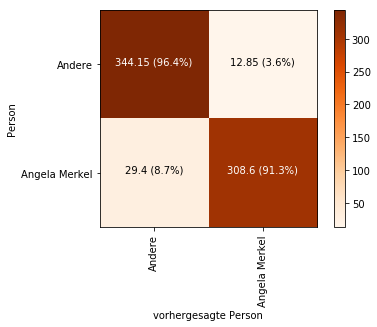

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

STEP_SIZE=0.6

# Ein GradientBoostingClassifier verwendet standardmäßig Entscheidungsbäume.
# Wir müssen noch die Höhe
def generate_gradient_boosting_classifier():
    return GradientBoostingClassifier(max_depth=DECISION_TREE_DEPTH,
                                      n_estimators=NUM_BASE_ESTIMATORS*2,
                                      learning_rate=STEP_SIZE)

(classifiers, accuracies, confusion_matrices) = train_and_test_repeated(
    classifier_generator=generate_gradient_boosting_classifier, 
    data=feature_vectors,
    labels=labels,
    test_size=TRAIN_TEST_RATIO,
    repetitions=REPETITIONS)

display_mean_accuracy(accuracies)
display_mean_confusion_matrix(confusion_matrices, classes=categories.unique())

## XGBoost

XGBoost stellt im Wesentlichen eine Verbesserung von herkömmlichem Gradient Boosting dar.
Beispielsweise erlaubt die Verwendung von Gradienten zweiter Ordnung eine bessere Bestimmung der Abstiegsrichtung und -weite.
Weiterhin werden Methoden zur besseren Vermeidung von Overfitting implementiert.
Zudem arbeitet XGBoost deutlich schneller und parallelisiert die Berechnungen von sehr großen Entscheidungsbäumen.
Für weiter Informationen und Hinweise, siehe das [codecentric.AI-Video](https://www.youtube.com/watch?v=xXZeVKP74ao) zum Thema XGBoost.

# Links
- [An intuitive explanation of gradient boosting](http://www.cse.chalmers.se/~richajo/dit865/files/gb_explainer.pdf)
- [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
- [A Gentle Introduction to Gradient Boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf)
- [Boosting Algorithms: AdaBoost, Gradient Boosting and XGBoost](https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c)